In [1]:
%matplotlib inline
import imp
import pandas as pd
import geopandas as gpd
import geopandas.tools
import pyproj
import numpy as np
from shapely.geometry import Point
import seaborn as sn
import matplotlib.pyplot as plt
sn.set_context('notebook')

# Prepare TEOTIL input files

For **unmonitored** locations, the RID programme uses the model [TEOTIL](https://brage.bibsys.no/xmlui/handle/11250/214825) to estimate fluxes of N and P to the coast. In addition to the modelled river flow data provided by NVE, TEOTIL requires the following input datasets:

 * **Avløp** (sewage and other drainage), sub-divided into
     * Large treatment works
     * Small treatment works
     * Other environmental pollutants <br><br>
     
 * **Fiskeoppdret** (Fish farming) <br><br>
 
 * **Industri** (industrial point sources) <br><br>
 
 * **Jordbruk** (land use and management activities)
 
The raw data comes from a variety of different sources and must be restructured into the format required by TEOTIL. This notebook performs this restructuring.

In [2]:
# Connect to db
resa2_basic_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Upload_Template'
                    r'\useful_resa2_code.py')

resa2_basic = imp.load_source('useful_resa2_code', resa2_basic_path)

engine, conn = resa2_basic.connect_to_resa2()

# Import custom RID functions
rid_func_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
                 r'\Python\rid\notebooks\useful_rid_code.py')

rid = imp.load_source('useful_rid_code', rid_func_path)

## 1. Store anlegg, Miljøgifter and Industri

These three datasets are all treated similarly, and there is some duplication between the files. Examples of the raw data formats are here:

 * K:\Prosjekter\Ferskvann\O-13255-TEOTIL\2016\Rådata\Avløp\TEOTIL store anlegg 2015 (sendt 18.08.2016).xlsx

 * K:\Prosjekter\Ferskvann\O-13255-TEOTIL\2016\Rådata\Avløp\Miljogifter_NIVA_RID-prosjektet_2015.xlsx

 * K:\Prosjekter\Ferskvann\O-13255-TEOTIL\2016\Rådata\Industri\Teotiluttrekket til NIVA - 2016_v2.xlsx

I have made local copies of these files here:

 * C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Report

and tidied all the column headings slightly. See also the information in the e-mail from John Rune received 29/06/2017 at 15.53. The data in these files must be added to two tables in RESA2:

 * First, the site data must be added to `RESA2.RID_PUNKTKILDER`. Most of the sites should already be there, but occasionally new sites are added. Any new stations must be be assigned lat/lon co-ordinates and the appropriate "Regine" catchment ID. This usually requires geocoding plus co-ordinate conversions and/or a spatial join to determine catchment IDs.
 
    **Note:** Many (>70) of the stations already in the database are missing Regine IDs. Many more (>3000) are missing co-ordinate information. We have previously asked Miljødirektoratet about this, but they have not yet provided the missing data. <br><br>
 
 * Secondly, the chemistry data for each site must be extracted and converted to "long" format, then added to `RESA2.RID_PUNKTKILDER_INPAR_VALUES`. Parameter IDs etc. are taken from `RESA2.RID_PUNKTKILDER_INPAR_DEF`.

In [3]:
# Read raw (tidied) data

# Store anlegg
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Report\avlop_stor_anlegg_2015_raw.xlsx')
stan_df = pd.read_excel(in_xlsx, sheetname='TEOTIL 2015 (sendt 18.08.16)')

# Miljøgifter
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Report\avlop_miljogifter_2015_raw.xlsx')
milo_df = pd.read_excel(in_xlsx, sheetname='Miljogifter_NIVA_RID-prosjektet')

# Industri
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Report\industri_2015_raw.xlsx')
ind_df = pd.read_excel(in_xlsx, sheetname='Sheet1')

# Drop blank rows
stan_df.dropna(how='all', inplace=True)
milo_df.dropna(how='all', inplace=True)
ind_df.dropna(how='all', inplace=True)

### 1.1. Basic data checking

All of the "Store Anlegg" and "Miljøgifter" sites are classified as `RENSEANLEGG` in the `TYPE` column of `RESA2.RID_PUNKTKILDER`; "Industri" sites as labelled `INDUSTRI`.

Add `TYPE` columns, merge site data from different sources, convert UTM co-ordinates to WGS84 decimal degrees and identify sites not already in the database. Issues identified below (e.g. missing co-ordinates) should be corrected if possible before continuing.

In [4]:
# Add TYPE cols
stan_df['TYPE'] = 'RENSEANLEGG'
milo_df['TYPE'] = 'RENSEANLEGG'
ind_df['TYPE'] = 'INDUSTRI'

# Get just stn info from each df
stan_loc = stan_df[['ANLEGGSNR', 'ANLEGGSNAVN', 'Kommunenr', 
                    'TYPE', 'Sone', 'UTM_E', 'UTM_N']]

milo_loc = milo_df[['ANLEGGSNR', 'ANLEGGSNAVN', 'KOMMUNE_NR', 
                    'TYPE', 'SONEBELTE', 'UTMOST', 'UTMNORD']]

ind_loc = ind_df[['Anleggsnr', 'Anleggsnavn', 'Komm.nr', 'TYPE', 
                  'Geografisk Longitude', 'Geografisk Latitude']]


# Rename cols
stan_loc.columns = ['anlegg_nr', 'anlegg_navn', 'komm_no',
                    'TYPE', 'zone', 'east', 'north']
milo_loc.columns = ['anlegg_nr', 'anlegg_navn', 'komm_no',
                    'TYPE', 'zone', 'east', 'north']
ind_loc.columns = ['anlegg_nr', 'anlegg_navn', 'komm_no',
                   'TYPE', 'lon', 'lat']

# Drop duplicates
stan_loc.drop_duplicates(inplace=True)
milo_loc.drop_duplicates(inplace=True)
ind_loc.drop_duplicates(inplace=True)

# Convert UTM to lat/lon
# "Industri" data is already in dd
stan_loc = rid.utm_to_wgs84_dd(stan_loc, 'zone', 'east', 'north')
milo_loc = rid.utm_to_wgs84_dd(milo_loc, 'zone', 'east', 'north')

# Remove UTM data 
del stan_loc['zone'], stan_loc['east'], stan_loc['north']
del milo_loc['zone'], milo_loc['east'], milo_loc['north']

# combine into single df
loc_df = pd.concat([stan_loc, milo_loc, ind_loc], axis=0)

# The same site can be in multiple files, so drop duplicates
loc_df.drop_duplicates(inplace=True)

# Kommune nr. should be a 4 char string, not a float
fmt = lambda x: '%04d' % x
loc_df['komm_no'] = loc_df['komm_no'].apply(fmt)

# Check ANLEGG_NR is unique
assert loc_df.index.duplicated().all() == False, 'Some "ANLEGGSNRs" are duplicated.'

# Check if any sites are not already in db
sql = ('SELECT UNIQUE(ANLEGG_NR) '
       'FROM resa2.rid_punktkilder')
annr_df = pd.read_sql_query(sql, engine)

not_in_db = set(loc_df['anlegg_nr'].values) - set(annr_df['anlegg_nr'].values)

print '\nThe following locations are not in the database:'
print loc_df[loc_df['anlegg_nr'].isin(list(not_in_db))][['anlegg_nr', 'anlegg_navn']]

# Check if any sites are missing co-ords
print '\nThe following locations do not have co-ordinates:'
print loc_df.query('(lat!=lat) or (lon!=lon)')[['anlegg_nr', 'anlegg_navn']]


The following locations are not in the database:
     anlegg_nr                     anlegg_navn
56    0226AL71     MIRA renseanlegg (v/Tangen)
63    0229AL07  Kirkebygden sentralrenseanlegg
353   0617AL19  Einarset Stølslag Felt H1 + H5
368   0619AL69                   Øyni menighet
402   0626AL64                     Tronstad RA
1069  1243AL38         OHARA avløpsrenseanlegg
1109  1246AL30                       Storanipa

The following locations do not have co-ordinates:
     anlegg_nr                             anlegg_navn
45    0215AL41                                  Bilitt
56    0226AL71             MIRA renseanlegg (v/Tangen)
63    0229AL07          Kirkebygden sentralrenseanlegg
238   0519AL58  Sjøsjålia-Tapptjønn-Fagerhøi hyttefelt
347   0615AL11           Damtjernhallin 2 avløpsanlegg
348   0616AL16                          SUTØYA CAMPING
353   0617AL19          Einarset Stølslag Felt H1 + H5
354   0617AL20                 Løggestølen renseanlegg
361   0618AL20              

C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


### 1.2. Identify Regine Vassdragsnummer

The shapefile here:

K:\Kart\Regine_2006\RegMinsteF.shp

shows locations for all the Regine catchments used by TEOTIL (see e-mail from John Rune received 29/06/2017 at 17.26). I've copied this file locally here:

C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Data\gis\shapefiles\RegMinsteF.shp

and re-projected it to WGS84 geographic co-ordinates. The new file is called *reg_minste_f_wgs84.shp*.

I have also written a function to perform a spatial join and identify which Regine polygon each point is located in.

**Note:** Geopandas is quite fussy about its input data (and also to install). The code below works, but the GDAL/OGR version [here](https://stackoverflow.com/a/13433127/505698) might be more robust?

In [5]:
# Path to Regine catchment shapefile
reg_shp_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
                r'\Data\gis\shapefiles\reg_minste_f_wgs84.shp')

# Spatial join
loc_df = rid.identify_point_in_polygon(loc_df, reg_shp_path, 
                                       'anlegg_nr', 'VASSDRAGNR',
                                       'lat', 'lon')

loc_df.head()

,TYPE,anlegg_navn,anlegg_nr,komm_no,lat,lon,VASSDRAGNR
0,RENSEANLEGG,Bakke,0101AL02,0101,59.019598,11.443762,001.2220
1,RENSEANLEGG,Kornsjø,0101AL06,0101,58.935184,11.668959,001.1J
2,RENSEANLEGG,Remmendalen avløpsanlegg,0101AL07,0101,59.120864,11.360106,001.31Z
3,RENSEANLEGG,Kambo,0104AL01,0104,59.474488,10.686496,003.20
4,RENSEANLEGG,Alvim Renseanlegg,0105AL00,0105,59.273056,11.075773,002.A4


### 1.3. Restructuring site data

For sites dataframe, rename columns to match RESA2.

In [6]:
# Rename other cols to match RESA2
loc_df['ANLEGG_NR'] = loc_df['anlegg_nr']
loc_df['ANLEGG_NAVN'] = loc_df['anlegg_navn']
loc_df['KNO'] = loc_df['komm_no']
loc_df['REGINE'] = loc_df['VASSDRAGNR']
loc_df['LON_UTL'] = loc_df['lon']
loc_df['LAT_UTL'] = loc_df['lat']

del loc_df['anlegg_nr'], loc_df['anlegg_navn'], loc_df['komm_no']
del loc_df['VASSDRAGNR'], loc_df['lon'], loc_df['lat']

loc_df.head()

,TYPE,ANLEGG_NR,ANLEGG_NAVN,KNO,REGINE,LON_UTL,LAT_UTL
0,RENSEANLEGG,0101AL02,Bakke,0101,001.2220,11.443762,59.019598
1,RENSEANLEGG,0101AL06,Kornsjø,0101,001.1J,11.668959,58.935184
2,RENSEANLEGG,0101AL07,Remmendalen avløpsanlegg,0101,001.31Z,11.360106,59.120864
3,RENSEANLEGG,0104AL01,Kambo,0104,003.20,10.686496,59.474488
4,RENSEANLEGG,0105AL00,Alvim Renseanlegg,0105,002.A4,11.075773,59.273056


In [7]:
# Get details for sites not already in db
loc_upld = loc_df[loc_df['ANLEGG_NR'].isin(list(not_in_db))]

loc_upld

,TYPE,ANLEGG_NR,ANLEGG_NAVN,KNO,REGINE,LON_UTL,LAT_UTL
56,RENSEANLEGG,0226AL71,MIRA renseanlegg (v/Tangen),0226,NaN,NaN,NaN
63,RENSEANLEGG,0229AL07,Kirkebygden sentralrenseanlegg,0229,NaN,NaN,NaN
353,RENSEANLEGG,0617AL19,Einarset Stølslag Felt H1 + H5,0617,NaN,NaN,NaN
368,RENSEANLEGG,0619AL69,Øyni menighet,0619,NaN,NaN,NaN
402,RENSEANLEGG,0626AL64,Tronstad RA,0626,NaN,NaN,NaN
1069,RENSEANLEGG,1243AL38,OHARA avløpsrenseanlegg,1243,NaN,NaN,NaN
1109,RENSEANLEGG,1246AL30,Storanipa,1246,NaN,NaN,NaN


In [8]:
# Add code to append these rows to RESA2.RID_PUNKTKILDER here

### 1.4. Restructuring values

In [9]:
# Set the year for the data in question
year = 2015

In [10]:
# Store Anlegg
# Get cols of interest 
stan_vals = stan_df[['ANLEGGSNR', 'MENGDE_P_UT_kg', 'MENGDE_N_UT_kg']]

# In RESA2.RID_PUNKTKILDER_INPAR_DEF, N is par_id 44 and P par_id 45
stan_vals.columns = ['ANLEGG_NR', 45, 44]

# Melt to "long" format
stan_vals = pd.melt(stan_vals, id_vars='ANLEGG_NR', value_vars=[45, 44],
                    var_name='INP_PAR_ID', value_name='VALUE')

# Drop NaN values
stan_vals.dropna(how='any', inplace=True)

As far as I can tell from exploring the 2015 data in the database, the main columns of interest for Miljøgifter are given in `milo_dict`, below, together with the corresponding parameter IDs from `RESA2.RID_PUNKTKILDER_INPAR_DEF`. This hard-coding is a bit messy, but I can't see any database table providing a nice lookup between these values, so they're included here for now.

In [11]:
# Miljøgifter
# Get cols of interest 
milo_dict = {'MILJOGIFTHG2':16, 
             'MILJOGIFTPAH2':48, 
             'MILJOGIFTPCB2':30, 
             'MILJOGIFTCD2':8, 
             'MILJOGIFTDEHP2':119, 
             'MILJOGIFTAS2':2,
             'MILJOGIFTCR2':10, 
             'MILJOGIFTPB2':28, 
             'MILJOGIFTNI2':25,
             'MILJOGIFTCU2':15, 
             'MILJOGIFTZN2':38, 
             'KONSMENGDTOTP10':45,
             'KONSMENGDTOTN10':44, 
             'KONSMENGDSS10':46,
             'ANLEGGSNR':'ANLEGG_NR'} # Make heading match RESA

milo_vals = milo_df[milo_dict.keys()]

# Get par IDs from dict
milo_vals.columns = [milo_dict[i] for i in milo_vals.columns]

# Melt to "long" format
milo_vals = pd.melt(milo_vals, id_vars='ANLEGG_NR',
                    var_name='INP_PAR_ID', value_name='VALUE')

# Drop NaN values
milo_vals.dropna(how='any', inplace=True)

The industry data is already in "long" format.

In [12]:
# Industri
# Get cols of interest
ind_vals = ind_df[['Anleggsnr', 'Komp.kode', 'Mengde', 'Enhet']]
ind_vals.columns = ['anlegg_nr', 'name', 'value', 'unit']

# Get par defs from db
# Check if any sites are not already in db
sql = ('SELECT * '
       'FROM resa2.rid_punktkilder_inpar_def')
par_df = pd.read_sql_query(sql, engine)

# Convert all units to capitals
ind_vals['unit'] = ind_vals['unit'].str.capitalize()
par_df['unit'] = par_df['unit'].str.capitalize()

# Join
ind_vals = pd.merge(ind_vals, par_df, how='left',
                    on=['name', 'unit'])

# Some parameters that are not of interest are not matched
# Drop these
ind_vals.dropna(how='any', inplace=True)

# Get just cols of interest
ind_vals = ind_vals[['anlegg_nr', 'in_pid', 'value']]

# Rename for db
ind_vals.columns = ['ANLEGG_NR', 'INP_PAR_ID', 'VALUE']

C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
# Combine
val_df = pd.concat([stan_vals, milo_vals, ind_vals], axis=0)

# Add column for year
val_df['YEAR'] = year

# Explicitly set data types
val_df['ANLEGG_NR'] = val_df['ANLEGG_NR'].astype(str)
val_df['INP_PAR_ID'] = val_df['INP_PAR_ID'].astype(int)
val_df['VALUE'] = val_df['VALUE'].astype(float)
val_df['YEAR'] = val_df['YEAR'].astype(int)

In [14]:
# Add code to append these rows to RESA2.RID_PUNKTKILDER_INPAR_VALUES here

**Remember to deal with unit conversions when manipulating these data later! In many cases, the same par is present with two units.**

## 2. Små anlegg (small treatment works)

An example of the raw data format is here:

K:\Prosjekter\Ferskvann\O-13255-TEOTIL\2016\Rådata\Avløp\TEOTIL små anlegg 2015 (sendt 18.08.2016).xlsx

I have made a local copy of this file here:

C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Report\avlop_sma_anlegg_2015_raw.xlsx

and deleted unnecessary columns. All of this data can be added directly to `RESA2.RID_KILDER_SPREDT_VALUES`. The kommuner ID numbers and names are in `RESA2.KOMMUNER`, but not all kommune IDs in `RID_KILDER_SPREDT_VALUES` are in `KOMMUNER`. Need to check to see if Tore's code actually uses the `KOMMUNER` table to link kommuners to OSPAR areas. If it does, **need to be careful**, but perhaps it's done directly on kommuner ID?

In [15]:
# Set the year for the data in question
year = 2015

In [16]:
# Read raw (tidied) data
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Report\avlop_sma_anlegg_2015_raw.xlsx')
sman_df = pd.read_excel(in_xlsx, 
                        sheetname=u'Teotil små 2015')
# Drop blank rows
sman_df.dropna(how='all', inplace=True)

# Kommune nr. should be a 4 char string, not a float
fmt = lambda x: '%04d' % x
sman_df['KOMMUNENR'] = sman_df['KOMMUNENR'].apply(fmt)

# Check if any kommuner are not already in db
sql = ('SELECT UNIQUE(kommune_no) '
       'FROM resa2.kommuner')
kmnr_df = pd.read_sql_query(sql, engine)

not_in_db = set(sman_df['KOMMUNENR'].values) - set(kmnr_df['kommune_no'].values)

print '\nThe following locations are not in the database:'
print sman_df[sman_df['KOMMUNENR'].isin(list(not_in_db))]

# Get cols of interest for RID_KILDER_SPREDT_VALUES
sman_df = sman_df[['KOMMUNENR', 'P_kg', 'N_kg']]

# In RESA2.RID_PUNKTKILDER_INPAR_DEF, N is par_id 44 and P par_id 45
sman_df.columns = ['KOMM_NO', 45, 44]

# Melt to "long" format
sman_df = pd.melt(sman_df, id_vars='KOMM_NO', value_vars=[45, 44],
                  var_name='INP_PAR_ID', value_name='VALUE')

# Add column for year
sman_df['YEAR'] = year

sman_df.head()


The following locations are not in the database:
    KOMMUNENR   KOMMUNENAVN        P_kg       N_kg
259      1505  Kristiansund  1433.17980   9554.532
292      1576          Aure  1438.50150   9951.360
340      1756       Inderøy  1292.87745   8896.875
386      1903       Harstad  2176.60815  14525.175


,KOMM_NO,INP_PAR_ID,VALUE,YEAR
0,0101,45,994.73085,2015
1,0104,45,113.10255,2015
2,0105,45,1372.60440,2015
3,0106,45,443.96775,2015
4,0111,45,29.59785,2015


In [17]:
# Add code here to append sman_df to `RESA2.RID_KILDER_SPREDT_VALUES`

Note, having added data to `RESA2.RID_KILDER_SPREDT_VALUES`, the procedure `RID_KILDER_OPPDATER` (and, specifically, `ESTIMATE_RID_SPREDT`, which is called from within it), should transfer these values to `RESA2.RID_KILDER_TIMESERIES`. However, this does not work in practice - no records are transferred - and, as a result, Tore's workflow (Oracle procedures + Excel VBA) currently produces a blank TEOTIL input file for `SPREDT.txt` - see section 5.1 (especially 5.1.3) below. **As a workaround, `SPREDT.txt` can be generated directly from the dataframe above**. I haven't coded this yet, but it should be easy based on code I have written for the other input files. Nevertheless, it would be good to know what Tore's old workflow actually did.

## 3. Fish farms

An examples of the raw data is here:

 * K:\Prosjekter\Ferskvann\O-13255-TEOTIL\2016\Rådata\Fiskeoppdrett\Teotil - 2015 (2) (pr. 09.08.16).xlsx.zip

I have made a local copy here:

 * C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Report

The data must be added to two tables in RESA2:

 * First, the site data must be added to `RESA2.RID_KILDER_AQUAKULTUR`. Most of the sites should already be there, but occasionally new sites are added. Any new stations must be be assigned lat/lon co-ordinates and the appropriate "Regine" catchment ID. This usually requires geocoding plus co-ordinate conversions and/or a spatial join to determine catchment IDs.
 
    **Note:** The key ID fields in the raw data appear to be `LOKNR` and `LOKNAVN`. <br><br>
 
 * Secondly, the chemistry data for each site must be extracted and converted to "long" format, then added to `RESA2.RID_KILDER_AQKULT_VALUES`. Parameter IDs etc. are taken from `RESA2.RID_PUNKTKILDER_INPAR_DEF`.
 
### 3.1. Basic data checking

In [18]:
# Set the year for the data in question
year = 2015

In [19]:
# Read raw (tidied) data
# Fish farms
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Report\fiske_oppdret_2015_raw.xlsx')
fish_df = pd.read_excel(in_xlsx, sheetname='Ark1')

# Drop no data
fish_df.dropna(how='all', inplace=True)

In [20]:
# Check if any sites are not already in db
sql = ('SELECT UNIQUE(NR) '
       'FROM resa2.rid_kilder_aquakultur')
aqua_df = pd.read_sql_query(sql, engine)

not_in_db = set(fish_df['LOKNR'].values) - set(aqua_df['nr'].values)

print '\nThe following locations are not in the database:'
print fish_df[fish_df['LOKNR'].isin(list(not_in_db))][['LOKNR', 'LOKNAVN']]


The following locations are not in the database:
Empty DataFrame
Columns: [LOKNR, LOKNAVN]
Index: []


### 3.2. Estimate nutrient inputs

The methodology here is a little unclear. The following is my best guess, based on the files located here:

K:\Avdeling\Vass\316_Miljøinformatikk\Prosjekter\RID\2016\Rådata\Fiskeoppdrett

Old workflow:

 1. Calculate the fish biomass from the raw data. See the equation in the `Biomasse` column of the spreadsheet *JSE_TEOTIL_2015.xlsx* <br><br>
 
 2. Split the data according to salmon ("laks"; species ID 71101) and trout ("øret"; species ID 71401), then group by location and month, summing biomass and `FORFORBRUK_KILO` columns (see Fiskeoppdrett_biomasse_2016.accdb) <br><br>
 
 3. Calculate production. This involves combining biomass for the current month with that for the previous month. See the calculations in e.g. *N_P_ørret_2015.xlsx*.
 
 4. Calculate NTAP and PTAP. **NB:** I don't know what these quantities are, so I'm just blindly duplicating the Excel calculations in the code below. The functions are therefore not very well explained
 
**NB:** RESA2 includes values for the usage of Cu in fish farms, but it's not clear to me where the raw data for this come from. **Check with John Rune**. The Cu data need integrating into the workflow below and the combined dataframe can then be added to `RESA2.RID_KILDER_AQKULT_VALUES`.

In [21]:
# Estimate nutrient inputs from fish farns
fish_nut = rid.estimate_fish_farm_nutrient_inputs(fish_df, year)

fish_nut.head()

,ANLEGG_NR,IN_PAR_ID,AR,MANED,ART,VALUE
0,10041,39,2015,6,NaN,62373.702416
1,10054,39,2015,6,NaN,44477.730830
2,10078,39,2015,6,NaN,80073.260644
3,10080,39,2015,6,NaN,110531.471188
4,10086,39,2015,6,NaN,4454.819248


In [22]:
# Add code here to append fish_sum to `RESA2.RID_KILDER_AQKULT_VALUES`
# NB: Need to add processing for Cu data first - see above

## 4. Land use

An examples of the raw data is here:

 * K:\Avdeling\Vass\316_Miljøinformatikk\Prosjekter\RID\2016\Rådata\Jordbruk\to-niva.2015.xls

Note that this file is not really an Excel file and opening it directly creates errors. I have corrected the data format, tidied the column headings and made a local copy here:

 * C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Report\jordbruk_2015.xlsx
 
This file does not get added to the database. Instead, it is restructured in Excel and then written directly to a text file in the correct format for TEOTIL. The Excel file for performing the restructuring is here:

 * K:\Avdeling\Vass\316_Miljøinformatikk\Prosjekter\RID\2016\Rådata\Jordbruk\Jordbrukskoef_Beregninger.xlsx

but it seems very messy. For example, the 2015 land use data seems to be in the 2014 sheet (not the 2015 sheet), and the column headings are labelled as being for 2011 (!). I'll attempt to tidy thhis up here.

The workflow seems to be as follows:

 1. Bioforsk provide nutrient input data (N and P) for 42 "Område", which are sub-divisions of the Fylke. This inlcudes "diffuse", "background" and "point" sources (presumably different point sources to the ones already considered above?) <br><br>
 
 2. For each område, NIVA has land use areas (just "agricultural" and "other" classes?) measured in **decares** (1/1000 km2; a unit common in Norway, but rare elsewhere). It looks as though these land use areas are assumed constant from year to year. <br><br>
 
 3. Some basic calculations (reproduced below) calculate inputs per square kilometre and these values are then written to a `;` separate text file with TEOTIL-specific headers.

To make things a bit neater, I have created a new file here:

C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Data\RID_Fylke-Sone_LU_Areas.xlsx

linking the Bioforsk Område codes to the NIVA fylke/sone land use areas (and converting the units to km2).

In [23]:
# Set the year for the data in question
year = 2015

# Path to (tidied) Bioforsk data
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Report\jordbruk_2015.xlsx')

# Output folder
out_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\Results\TEOTIL_Inputs')

# Write TEOTIL LU coefficients
rid.estimate_teotil_land_use_coefficients(in_xlsx, 'jordbruk_2015', 
                                          year, out_fold)

## 5. Generating input files

### 5.1. Understanding `RESA2.RID_KILDER_OPPDATER`

Once all the raw data has been added to the database, there seems to be quite a complictaed workflow for generating the actual TEOTIL input files. The procedure `RID_KILDER_OPPDATER` is run to update the `RID_KILDER_TIMESERIES` table, and then VBA code (in the Excel file `code.xls`) is used to restructure the values in this table into the text files required by the model. The procedure `RID_KILDER_OPPDATER` calls several other procedures: `CALC_RID_KILDER`, `ESTIMATE_RID_AQUAKULTUR`, `ESTIMATE_RID_KILDER`, `ESTIMATE_RID_SPREDT` and `CHECK_RID_KILDER`.

**For now, I have decided to leave this part of the workflow alone, as it is relatively easy to run `RID_KILDER_OPPDATER` when needed**. This all needs recoding eventually, but tidying up the mix of Access, Excel and VBA code elsewhere is more of a priority at present. As a start, see the notes below for what some of these procedures actually do.

#### 5.1.1. `CALC_RID_KILDER`

This loops over all of the parameters in `RID_PUNKTKILDER` and `RID_KILDER_SPREDT_VALUES` and calculates the Sen's slope based on annual data from 1990 up to the current year. Results are written to `RID_KILDER_STATISTIC`. As far as I can tell, this has nothing to do with running TEOTIL, so I'll ignore it for now.

#### 5.1.2. `ESTIMATE_RID_AQUAKULTUR`

This transfers data from `RID_KILDER_AQUAKULTUR` and `RID_KILDER_AQKULT_VALUES` to `RID_KILDER_TIMESERIES`. The code below is copied more-or-less directly from Tore's procedure (with some additional comments).

In [24]:
# Specify timeseries ID
# Currently defined in RID_TIMESERIES_DEFINITIONS
# Not sure it's strictly necessary, but keep for now for compatibility
#ts_id = 11

In [25]:
# Delete any aquaculture data already in `RID_KILDER_TIMESERIES`
# for this ts_id
#sql = ("DELETE FROM resa2.rid_kilder_timeseries "
#       "WHERE timeseries_id = %s AND type = 'AKVAKULTUR'" % ts_id)
#
#res = conn.execute(sql)

In [26]:
# Insert new data for this ts_id
#sql = ("INSERT INTO resa2.rid_kilder_timeseries ( "
#       "  SELECT %s, a.anlegg_nr, b.regine, c.out_pid, a.ar, "
#       "    sum(a.value*c.factor), 0, 'AKVAKULTUR', null "
#       "  FROM resa2.rid_kilder_aqkult_values a, "
#       "    resa2.rid_kilder_aquakultur b, "
#       "    resa2.rid_punktkilder_inp_outp c "
#       "  WHERE a.anlegg_nr = b.nr "
#       "  AND a.inp_par_id = c.in_pid "
#       "  GROUP BY 1, a.anlegg_nr, b.regine, c.out_pid, a.ar, "
#       "    0, 'AKVAKULTUR')" % ts_id)
#
#res = conn.execute(sql)

In [27]:
# Aquaculture data for 1991 seem to be missing
# Tore's procedure therefore patches with values
# midway between 1990 and 1992
#sql = ("INSERT INTO resa2.rid_kilder_timeseries ( "
#       "  SELECT a.timeseries_id, a.id, a.regine, a.parameter_id, "
#       "    1991, (a.xvalue+b.xvalue)/2, 1 , a.type, null "      
#       "  FROM "
#       "    (SELECT * from resa2.rid_kilder_timeseries "
#       "     WHERE year = 1990 "
#       "     AND timeseries_id = %s) a, "
#       "    (SELECT * from resa2.rid_kilder_timeseries "
#       "     WHERE year = 1992 "
#       "     AND timeseries_id = %s) b "
#       "  WHERE a.id = b.id "
#       "  AND a.parameter_id = b.parameter_id "
#       "  AND a.type = 'AKVAKULTUR')" % (ts_id, ts_id))
#
#res = conn.execute(sql)

#### 5.1.3. `ESTIMATE_RID_SPREDT`

In principle, the code here transfers values from `RID_KILDER_SPREDT_VALUES` to `RID_KILDER_TIMESERIES`. However, although the procedure runs, it does not actually transfer any data beyond 2009 (there's a lot of "fixing/correcting" code in this procedure that I haven't looked into in detail yet. **I'm not sure how Tore has generated the `SPREDT.txt` input file for TEOTIL, as his code in `code.xls` does not produce any results**. It is nevertheless easy to generate this input file directly from `RID_KILDER_SPREDT_VALUES` - all that is required is a simple pivot followed by unit conversions from kg to tonnes. However, **there is clearly a discontinuity in the old workflow here, which needs to be explained**.

### 5.2. Writing TEOTIL text files

Sections 1 to 4 above cover the preparation and upload of the basic datasets required for TEOTIL. Once this has been done, it is currently still necessary to run the procedure `RID_KILDER_OPPDATER`, which updates the `RID_KILDER_TIMESERIES` table (see section 5). The next step in Tore's old workflow involved running the VBA code in the *WriteOutputTeotil* module of this file:

 * K:\Avdeling\Vass\316_Miljøinformatikk\Prosjekter\RID\Rekonstruksjon\code.xls
 
This approach is a little messy, so it's recoded below.

In [28]:
# Set the year, ts_id and output folder
year = 2015
ts_id = 9
out_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\Results\TEOTIL_Inputs')

#### 5.2.1. Renseanlegg, Spredt, Akvakultur and Industri

In [29]:
# Write inputs for point sources
for typ in ['RENSEANLEGG', 'SPREDT', 'INDUSTRI', 'AKVAKULTUR']:
    rid.write_teotil_point_source_input_file(out_fold, ts_id,
                                             year, typ, engine)    

#### 5.2.2. Discharge

The TEOTIL discharge file seems to require, for each of the NVE modelled locations, the following flow statistics (all in m3/s):

 * Annual mean flow for the year in question
 * Long-term annual mean flow (1990 to 2008)
 * Monthly mean flow for the year in question
 
In Tore's Excel file (*code.xls*), this file is created by the sub-routine `GetdataQ`.

**Note:** I think there may be a mistake in the code here. Tore's code extracts monthly flow averages for each discharge station using the following SQL statement (for example):

    SELECT TO_CHAR(xdate,'MM'), ROUND(AVG(xvalue), 6) as q
    FROM resa2.discharge_values 
    WHERE dis_station_id = 66
    AND TO_CHAR(xdate, 'YYYY') = 2015
    GROUP BY TO_CHAR(xdate, 'MM');
    
The Excel code then loops over this result and sequentially inserts values into the TEOTIL input file. However, the above SQL is missing an `ORDER BY` statement, so the query returns results in a random order, whereas the VBA code assumes the values are ordered by month. This means that, for the example above, the mean discharge for April is incorrectly assigned to January, the discharge for August to February, the discharge for September to March and so on. In other words, **the monthly flow averages are correct, but they are assigned to random months in the TEOTIL file**. This is the case for *all* the TEOTIL flow data.

Without knowing more about how TEOTIL works (i.e. what role the monthly data play in the model), it's unclear how much of a problem this is. If the model includes any kind of seasonality in the agriculture/crop growth component, it's potentially a major issue.

In [30]:
# Write inputs for discharge
rid.write_teotil_discharge_input_file(out_fold, year, engine)  

#### 5.2.3. Observed loads

The final set of inputs for TEOTIL is a set of files summarising observed loads at the 155 sites in the RID project. In the past, Tore has calculated two files: one based on loads assuming all LOD values are at the limit of detection (*RID_Observert_Upper.txt*) and another assuming all LOD values are zero (*RID_Observert_Lower.txt*). The new methodology uses a different approach for dealing with LOD values (see section 2.3.2 of [this notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/rid_data_exploration.ipynb) for details), but I'm not sure whether TEOTIL still needs the data in the old format. For now, the best approach I can think of is to generate a single file based on the new methodlogy and then duplicate it i.e. there will still be two files named *RID_Observert_Upper.txt* and *RID_Observert_Lower.txt*, but they will be exactly the same, and the values will be based on the new loads calculation approach.

This required file can be generated quite easily from the output of [loads estimation notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/estimate_loads.ipynb). Note that Tore's old version includes loads for `HCHG` and `SUMPCB`, but as far as I can tell these are no longer being measured (data exist for the early years, but not for 2015). The code below simply adds two blank columns for these parameters, **but this will need changing if these parameters are actually still being analysed**.

**Note:** The some of the units in Tore's input file appear to be incorrect. All the column headings specify tonnes, but the values for SiO2, SPM and TOC are in all actually megatonnes. **Need to check what TEOTIL actually expects, as this could also make a big difference to the output**.

**Note 2:** Tore's analysis explicitly excludes Glomma (station_id 29617). **Why is this?**

**Note 3:** Tore's analysis only includes data from 13 stations - values for all the others are set to -9999. **Why is this?**

In [31]:
# Write inputs for observed
loads_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
              r'\Results\Loads_CSVs\loads_all_sites_2015.csv')

rid.write_teotil_observed_input_file(out_fold, loads_path, engine)

## 6. Run TEOTIL

The model is located here:

K:\Avdeling\Vass\Teotil2\Teotil2.exe

A number of paths in the model are hard-coded in the input parameter files, so the easiest way to run it is as follows:

 1. Delete everything from this folder:
 
         K:\Avdeling\Vass\Teotil2\Norge_Regine\RID_tilforsler\Run
         
  **Except** *Run_totN_Norge_Regine.run* and *Run_totP_Norge_Regine.run*, which are the (static) model parameter files. <br><br>
  
 2. Copy all the input TEOTIL files to this folder (and do not change any of the file names):
 
         - Q_Vassdrag.txt
         - RID_Observert_Lower.txt         
         - RID_Observert_Upper.txt
         - AKVAKULTUR.txt
         - INDUSTRI.txt
         - RENSEANLEGG.txt
         - SPREDT.txt
         - Koeffisienter_jordbruk.txt
         
 3. Run *Teotil2.exe*. In the *File* input box, browse to *Run_totN_Norge_Regine.run* and click *Run*. The model will calculate N loads and write the results to *totN_lokal.txt* (the other output files generated can be ignored). <br><br>
 
 4. Repeat step 3, but this time specify *Run_totP_Norge_Regine.run* to calculate results for P, which are written to *totP_lokal.txt*. <br><br>
 
 5. Copy the results to another folder for storage (anything in the `Run` folder will be deleted/over-written next time the model is run). Previous results for the RID project are stored in `year` folders here:
 
         K:\Avdeling\Vass\Teotil2\Norge_Regine\RID_tilforsler
 
**Note:** The model runs slowly - a single run may take 3 to 4 hours (i.e. 6 to 8 hours for N and P combined).

## 7. Comparing new and old model output

### 7.1. Output files for N

The code below compares old and new ouptut for N.

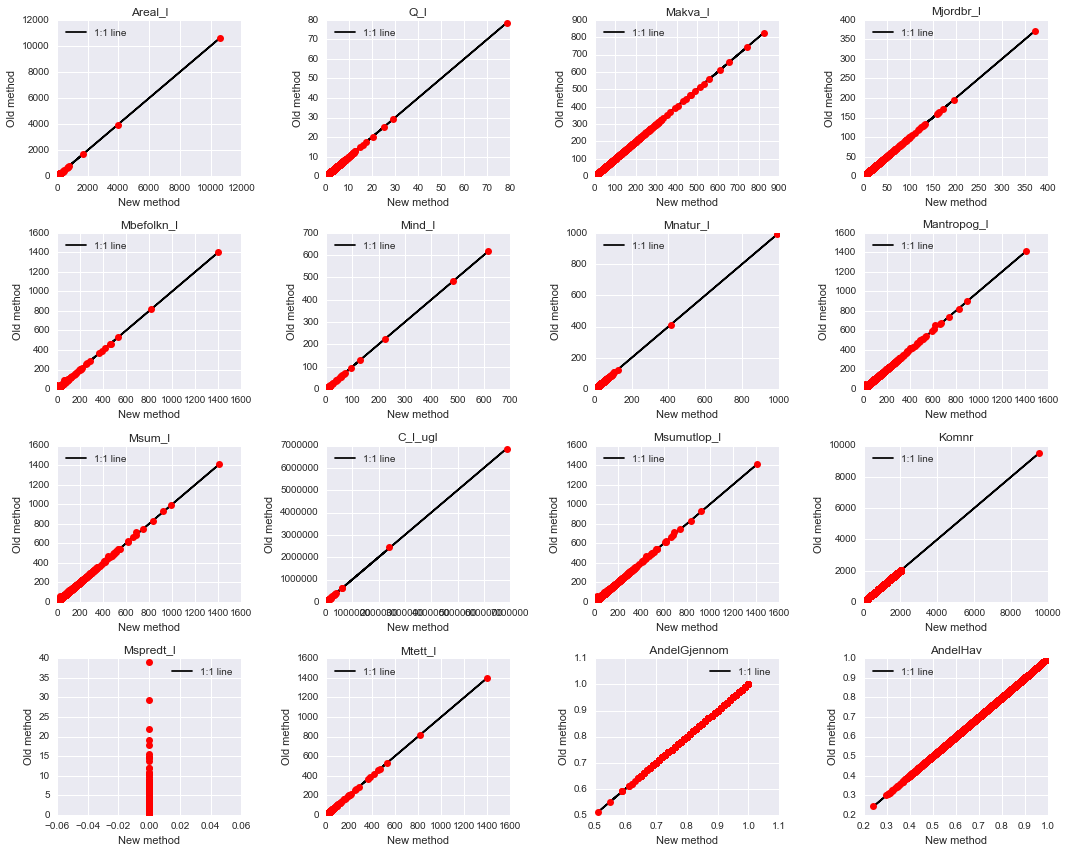

In [32]:
# Read Tore's TEOTIL results
in_csv = (r'K:\Avdeling\Vass\Teotil2\Norge_Regine\RID_tilforsler\2015\totN_lokal.txt')
old_df = pd.read_csv(in_csv, sep=';', index_col=0)
del old_df['Year']

# Read new TEOTIL output
in_csv = (r'K:\Avdeling\Vass\Teotil2\Norge_Regine\RID_tilforsler\Run\totN_lokal.txt')
new_df = pd.read_csv(in_csv, sep=';', index_col=0)
del new_df['Year']

# Get col names of interest for plotting
cols = new_df.columns

# Join old and new
df = pd.merge(old_df, new_df, how='outer', 
              suffixes=['_old', '_new'],
              left_index=True, right_index=True)

# Plot
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,12))
axes = axes.flatten()

# Loop over subplots
for idx, col in enumerate(cols):
    axes[idx].plot(df[col+'_new'], df[col+'_new'], 
                   'k-', label='1:1 line')
    axes[idx].plot(df[col+'_new'], df[col+'_old'], 
                   'ro', label='')    
    axes[idx].set_xlabel('New method')
    axes[idx].set_ylabel('Old method')
    axes[idx].set_title(col)
    axes[idx].legend(loc='best')
plt.tight_layout()    
plt.show()

### 7.2. Output files for P

And the code below shows the same for P.

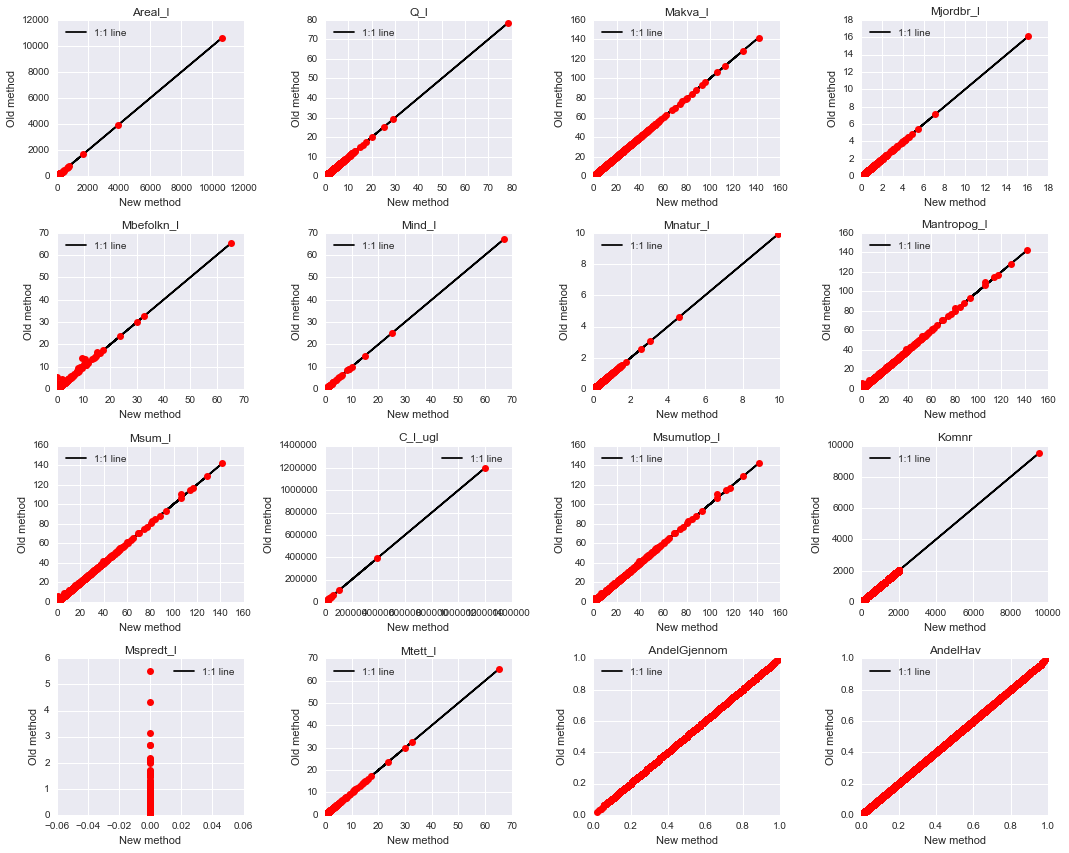

In [33]:
# Read Tore's TEOTIL results
in_csv = (r'K:\Avdeling\Vass\Teotil2\Norge_Regine\RID_tilforsler\2015\totP_lokal.txt')
old_df = pd.read_csv(in_csv, sep=';', index_col=0)
del old_df['Year']

# Read new TEOTIL output
in_csv = (r'K:\Avdeling\Vass\Teotil2\Norge_Regine\RID_tilforsler\Run\totP_lokal.txt')
new_df = pd.read_csv(in_csv, sep=';', index_col=0)
del new_df['Year']

# Get col names of interest for plotting
cols = new_df.columns

# Join old and new
df = pd.merge(old_df, new_df, how='outer', 
              suffixes=['_old', '_new'],
              left_index=True, right_index=True)

# Plot
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,12))
axes = axes.flatten()

# Loop over subplots
for idx, col in enumerate(cols):
    axes[idx].plot(df[col+'_new'], df[col+'_new'], 
                   'k-', label='1:1 line')
    axes[idx].plot(df[col+'_new'], df[col+'_old'], 
                   'ro', label='')    
    axes[idx].set_xlabel('New method')
    axes[idx].set_ylabel('Old method')
    axes[idx].set_title(col)
    axes[idx].legend(loc='best')
plt.tight_layout()    
plt.show()

The old and new TEOTIL runs produce essentially identical outputs in all cases. The only exception is for `SPREDT`, because my code currently uses output from Tore's `RID_KILDER_OPPDATER` procedure, which doesn't include any values for "spredt". In theory, this is the same as Tore's workflow, but in practice he must be using some other code that I'm not aware of. Regardless, this is easy to fix - see sections 2 and 5.1.3 above for details.

The fact that the model results from the two approaches are the same is actually a little bit worrying, because my input files are substantially different from Tore's (see the notes above regarding unit conversions and monthly flow summaries). SiO2, SPM and TOC do not significantly affect N loads, so the unit issues are perhaps not important for N, but SPM is certainly relevant for P, and the fact that my SPM values are a factor of $1.10^6$ larger than Tore's should make a difference. Furthermore, the monthly flows are significantly different between model runs, because the flow averages in the old input files are wrong (see section 5.2.2). **It therefore appears that the TEOTIL estimated loads are more-or-less insensitive to hydrology**, which is not realistic.

**These issues need further investigation**.